In [2]:
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import shap
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pickle
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [4]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
1,1,1,1,4,48,IDA BAGUS MADE DARMA WIGUNA,"Pada bulan Februari dan Maret 2024, terdakwa I...",24.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
3,2,2,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
4,2,3,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4318,2,269,118,2,240,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",72.0
4319,0,257,107,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4320,0,280,107,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4321,0,257,107,2,84,ANWAR RURI BIN SYARIFUDIN USMAN,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0


In [5]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

train_df, test_df = stratified_split(df)

{(0, 0, 0): [0, 20, 42], (0, 0, 2): [2], (0, 1, 0): [19, 37], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 5, 21): [843], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 12, 19): [775, 776, 813], (0, 12, 21): [774], (0, 12, 22): [715], (0, 12, 23): [806], (0, 13, 0): [32], (0, 13, 3): [34], (0, 14, 0): [38], (0, 14, 14): [437, 501, 595, 609], (0, 14, 16): [422], (0, 14, 18): [474, 665], (0, 14, 19): [783, 784, 785, 786], (0, 14, 20): [432, 438, 518, 578, 608, 724, 745], (0, 14, 21): [639, 822], (0, 15, 4): [33], (0, 16, 0): [39], (0, 17, 0): [40, 41], (0, 19, 7): [46], (0, 20, 36): [1051], (0, 21, 52): [1612], (0, 21, 54): [1630, 1632], (0, 22, 10): [241, 268, 269, 270, 271, 303], (0, 22, 14): [259, 381, 415, 416, 538, 545, 577, 621], (0, 22, 16): [308, 314, 315, 383, 386, 417], (0, 22, 18): [654, 655, 656], (0, 22, 19): [548, 762], (0, 22, 20): [446, 570, 571, 572, 573, 690, 725], (0, 22, 22): [719], (0, 23, 10): [52, 54], (0, 24, 10): 

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [6]:
train_df, test_df = stratified_split(df)

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


{(0, 0, 0): [0, 20, 42], (0, 0, 2): [2], (0, 1, 0): [19, 37], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 5, 21): [843], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 12, 19): [775, 776, 813], (0, 12, 21): [774], (0, 12, 22): [715], (0, 12, 23): [806], (0, 13, 0): [32], (0, 13, 3): [34], (0, 14, 0): [38], (0, 14, 14): [437, 501, 595, 609], (0, 14, 16): [422], (0, 14, 18): [474, 665], (0, 14, 19): [783, 784, 785, 786], (0, 14, 20): [432, 438, 518, 578, 608, 724, 745], (0, 14, 21): [639, 822], (0, 15, 4): [33], (0, 16, 0): [39], (0, 17, 0): [40, 41], (0, 19, 7): [46], (0, 20, 36): [1051], (0, 21, 52): [1612], (0, 21, 54): [1630, 1632], (0, 22, 10): [241, 268, 269, 270, 271, 303], (0, 22, 14): [259, 381, 415, 416, 538, 545, 577, 621], (0, 22, 16): [308, 314, 315, 383, 386, 417], (0, 22, 18): [654, 655, 656], (0, 22, 19): [548, 762], (0, 22, 20): [446, 570, 571, 572, 573, 690, 725], (0, 22, 22): [719], (0, 23, 10): [52, 54], (0, 24, 10): 

In [7]:
model_scenario_name = "BiLSTM_12"
max_len = 1024

model_save_path = f'../Model/{model_scenario_name}'
tokenizer_save_path = f'../Model/{model_scenario_name}_tokenizer.pkl'
history_training_save_path = f'../Model/{model_scenario_name}_training_history.pkl'
    
loaded_model = tf.keras.models.load_model(model_save_path)

with open(tokenizer_save_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [8]:
train_df['concat_text'] = train_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)
test_df['concat_text'] = test_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)

y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s\(\)]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['normalized_text'] = train_df['concat_text'].apply(normalize_text)
test_df['normalized_text'] = test_df['concat_text'].apply(normalize_text)

stopword_factory = StopWordRemoverFactory()
stop_words = set(stopword_factory.get_stop_words())

def remove_stopwords(text, stop_words):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df['stopword_removal'] = train_df['normalized_text'].apply(lambda x: remove_stopwords(x, stop_words))
test_df['stopword_removal'] = test_df['normalized_text'].apply(lambda x: remove_stopwords(x, stop_words))

In [9]:
# Tokenisasi
train_sequences = tokenizer.texts_to_sequences(train_df['stopword_removal'])
test_sequences = tokenizer.texts_to_sequences(test_df['stopword_removal'])

In [10]:
# Padding
max_len = 1024
X_train_texts = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_texts = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [11]:
# train_numerical = train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values
test_numerical = tf.constant(test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values, dtype=tf.float32)

## Monte Carlo Dropout

In [12]:
import gc

class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)
    
def apply_mc_dropout(model):
    def convert_layer(layer):
        if isinstance(layer, tf.keras.layers.Dropout):
            config = layer.get_config()
            return MCDropout.from_config(config)
        return layer

    new_model = tf.keras.models.clone_model(model, clone_function=convert_layer)
    new_model.set_weights(model.get_weights())
    return new_model

mc_model = apply_mc_dropout(loaded_model)

del loaded_model


tf.keras.backend.clear_session()
gc.collect()
tf.compat.v1.reset_default_graph()

In [ ]:
def mc_dropout_prediction(model, x_input, n_iter):
    preds = [model(x_input, training=False).numpy() for _ in range(n_iter)]
    preds = np.array(preds)
    
    mean = np.mean(preds, axis=0).squeeze()
    std = np.std(preds, axis=0).squeeze()
    
    return mean, std

In [14]:
X_text_expanded = np.expand_dims(X_test_texts, axis=1)         # Shape: (total, 1, ...)
numerical_expanded = np.expand_dims(test_numerical, axis=1)    # Shape: (total, 1, ...)


In [21]:
total = 100
n_iter = 1

mean_preds = np.zeros(total)
std_values = np.zeros(total)

for i in tqdm(range(total)):
    x_text = X_text_expanded[i]
    x_numerical = numerical_expanded[i]
    x = [x_text, x_numerical]

    mean_pred, std = mc_dropout_prediction(mc_model, x, n_iter=n_iter)
    
    mean_preds[i] = mean_pred
    std_values[i] = std

mcdropout_df = pd.DataFrame({
    'mean_pred': mean_preds,
    'std': std_values
})



100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


| Confidence Level | z-score (z) |
| ---------------- | ----------- |
| 80%              | 1.28        |
| 85%              | 1.44        |
| 90%              | 1.645       |
| 95%              | 1.96        |
| 98%              | 2.33        |
| 99%              | 2.58        |
| 99.9%            | 3.29        |

In [ ]:
correct = 0
# y_true = y_test.iloc[i]
# ci_bounds = []    
    # ci_lower = mean - z * std
    # ci_upper = mean + z * std

    # ci_bounds.append((ci_low, ci_up))
    
    # if ci_low <= y_true <= ci_up:
    #     correct += 1

# coverage = correct / total * 100
# print(f"Confidence Interval Coverage (95% CI): {coverage:.2f}%")


In [14]:
mcdropout_df

,mean_pred,std
0,18.497313,1.702418
1,30.287266,3.0003607
2,7.329079,1.3188144
3,14.517017,1.5630454
4,14.487258,1.5523822


In [18]:
mcdropout_df.to_csv(f'../Confidence Interval/mcdropout_iteration_{n_iter}.csv')

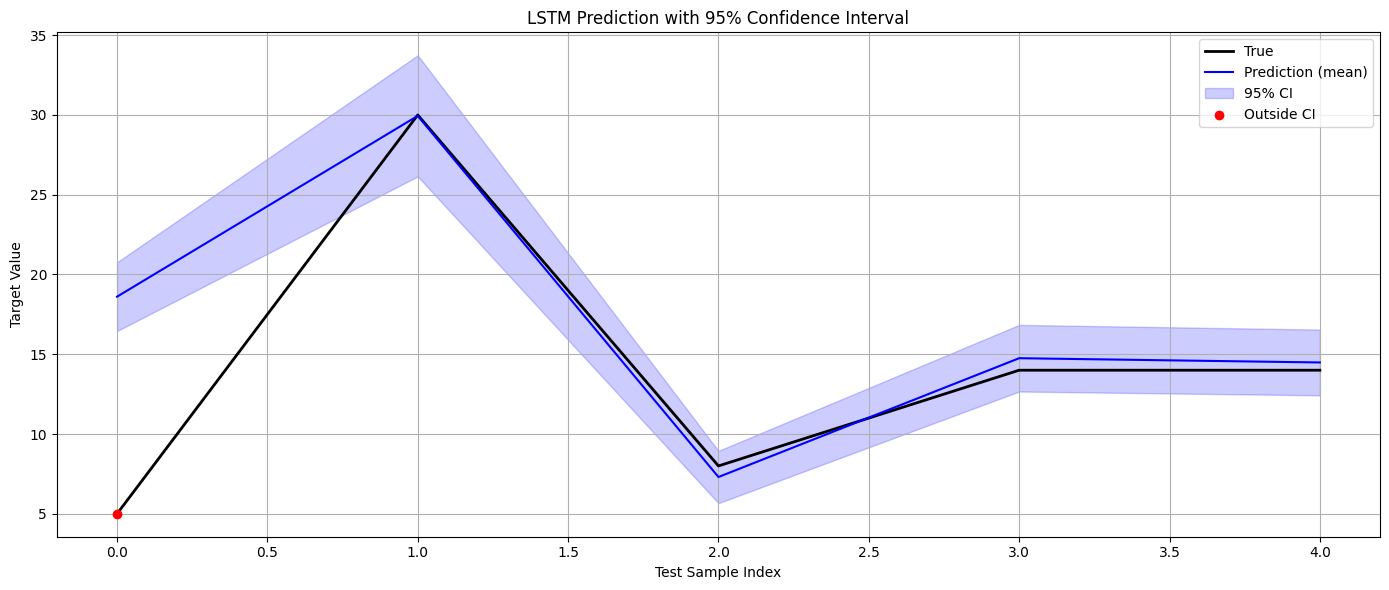

In [19]:
y_true_list = y_test.to_list()
y_pred_arr = np.array(y_preds)
y_true_arr = np.array(y_true_list[:total])
ci_low_arr = np.array([ci[0] for ci in ci_bounds])
ci_up_arr  = np.array([ci[1] for ci in ci_bounds])
x_axis = np.arange(len(y_true_arr))

plt.figure(figsize=(14, 6))

# Plot prediksi dan ground truth
plt.plot(x_axis, y_true_arr, label='True', color='black', linewidth=2)
plt.plot(x_axis, y_pred_arr, label='Prediction (mean)', color='blue')

# Area Confidence Interval
plt.fill_between(x_axis, ci_low_arr, ci_up_arr, color='blue', alpha=0.2, label='95% CI')

# Titik-titik yang berada di luar CI
out_of_bounds = (y_true_arr < ci_low_arr) | (y_true_arr > ci_up_arr)
plt.scatter(x_axis[out_of_bounds], y_true_arr[out_of_bounds], color='red', label='Outside CI', zorder=5)

plt.title("LSTM Prediction with 95% Confidence Interval")
plt.xlabel("Test Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
test_df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan,concat_text,normalized_text,stopword_removal
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.000000,GEDE DARMAYASA. Terdakwa Gede Darmayasa didakw...,gede darmayasa terdakwa gede darmayasa didakwa...,gede darmayasa terdakwa gede darmayasa didakwa...
37,0,1,0,6,80,Gede Kastawa,Terdakwa Gede Kastawa didakwa melakukan serang...,30.000000,Gede Kastawa. Terdakwa Gede Kastawa didakwa me...,gede kastawa terdakwa gede kastawa didakwa mel...,gede kastawa terdakwa gede kastawa didakwa mel...
36,0,1,4,3,84,GUNAWAN,"Pada Minggu, 11 Desember 2022 sekitar pukul 00...",8.000000,"GUNAWAN. Pada Minggu, 11 Desember 2022 sekitar...",gunawan pada minggu 11 desember 2022 sekitar p...,gunawan minggu 11 desember 2022 pukul 0030 wit...
17,0,8,0,6,144,ROSITA EVAYANTI DEWI,Terdakwa I Ketut Joni Adnyana Adi Putra dan Te...,14.000000,ROSITA EVAYANTI DEWI. Terdakwa I Ketut Joni Ad...,rosita evayanti dewi terdakwa i ketut joni adn...,rosita evayanti dewi terdakwa i ketut joni adn...
18,0,9,0,6,144,ROSITA EVAYANTI DEWI,Terdakwa I Ketut Joni Adnyana Adi Putra dan Te...,14.000000,ROSITA EVAYANTI DEWI. Terdakwa I Ketut Joni Ad...,rosita evayanti dewi terdakwa i ketut joni adn...,rosita evayanti dewi terdakwa i ketut joni adn...
...,...,...,...,...,...,...,...,...,...,...,...
2466,4,221,80,3,120,Nyoman Sudiarta alias Comek,Terdakwa NYOMAN SUDIARTA alias COMEK telah men...,30.500000,Nyoman Sudiarta alias Comek. Terdakwa NYOMAN S...,nyoman sudiarta alias comek terdakwa nyoman su...,nyoman sudiarta alias comek terdakwa nyoman su...
2375,4,222,80,1,120,I Nyoman Sentana,"Pada hari Minggu, 18 November 2018, sekitar pu...",3.666667,"I Nyoman Sentana. Pada hari Minggu, 18 Novembe...",i nyoman sentana pada hari minggu 18 november ...,i nyoman sentana hari minggu 18 november 2018 ...
4093,4,259,119,2,120,NA'IM Bin Alm SARNAN,"Pada hari Minggu, 09 Juli 2023, sekitar pukul ...",8.000000,"NA'IM Bin Alm SARNAN. Pada hari Minggu, 09 Jul...",naim bin alm sarnan pada hari minggu 09 juli 2...,naim bin alm sarnan hari minggu 09 juli 2023 p...
4086,4,259,119,2,120,RASMAN Bin RASIM,"Pada Minggu, 09 Juli 2023, sekitar pukul 00.15...",8.000000,"RASMAN Bin RASIM. Pada Minggu, 09 Juli 2023, s...",rasman bin rasim pada minggu 09 juli 2023 seki...,rasman bin rasim minggu 09 juli 2023 pukul 001...


In [31]:
klasifikasi_perkara_encoded = 0
penuntut_umum_encoded = 0
hakim_encoded = 1
jumlah_saksi_inference = 6
maks_penjara_berdasarkan_pasal = 80

indexs = 37
TRUE_VALUES = y_test[indexs]

inference_text = [test_df['stopword_removal'][indexs]]
inference_numerical_tensor = tf.constant([[klasifikasi_perkara_encoded, penuntut_umum_encoded, hakim_encoded, jumlah_saksi_inference, maks_penjara_berdasarkan_pasal]], dtype=tf.float32)

new_sequences = tokenizer.texts_to_sequences(inference_text)
inference_text = tf.keras.preprocessing.sequence.pad_sequences(new_sequences, maxlen=max_len, padding='post')


predictions = loaded_model.predict([inference_text, inference_numerical_tensor])
print(f'Predicted Putusan: {predictions[0]}')

print(TRUE_VALUES)

# pred_log = predictions[0].astype(float)  # Log transformation
# predictions = np.expm1(pred_log)  
# print(f'Predicted Putusan: {predictions}')

1/1 [==============================] - 0s 263ms/step
Predicted Putusan: [29.65912]
30.0


In [ ]:
preds = []
for _ in range(100):
    pred = mc_model([inference_text, inference_numerical_tensor], training=False)
    preds.append(pred.numpy().squeeze())
    print(_, pred)

mean = np.mean(preds)
std = np.std(preds)

print(mean)
print(std)


0 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
1 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
2 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
3 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
4 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
5 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
6 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
7 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
8 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
9 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
10 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
11 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
12 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
13 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
14 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
15 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
16 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
17 tf.Tensor([[29.65912]], shape=(1, 1), dtype=float32)
18

KeyboardInterrupt: 